### Air Passengers Prediction

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [1]:
#Time series model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [5]:
import pandas as pd
import numpy as np

In [7]:
#Importing Data
df = pd.read_csv('AirPassengers.csv', parse_dates=True, index_col='Month')

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
#Spliting train and test data
length = int(len(df)*0.67)
X_train = df.iloc[:length,:]
X_test = df.iloc[length:,:]

In [5]:
X_train.shape

(96, 1)

In [6]:
X_test.shape

(48, 1)

In [7]:
###Scaling
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [8]:
look_back = 5
trainX, trainY = create_dataset(X_train_sc, look_back)
testX, testY = create_dataset(X_test_sc, look_back)

In [94]:
X_train_sc[-5:]

array([[0.97411003],
       [0.81229773],
       [0.65372168],
       [0.54045307],
       [0.65372168]])

In [97]:
trainY[-5:]

array([1.        , 0.97411003, 0.81229773, 0.65372168, 0.54045307])

In [9]:
#Reshaping the from 2D --> 3D
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],1))

In [43]:
def metrics(y_true, y_pred):
    print('MAE:', mean_absolute_error(y_true, y_pred))
    print('MSE:', mean_squared_error(y_true, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))

In [11]:
#Creating model
def Simple_rnn_model(): 
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(look_back,1), return_sequences=True))
    model.add(SimpleRNN(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [12]:
model1 = Simple_rnn_model()

In [13]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5, 50)             2600      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1.fit(trainX, trainY, epochs=100, verbose=1, validation_data=(testX, testY))

Epoch 1/100
3/3 [==============================] - 2s 182ms/step - loss: 0.1141 - mse: 0.1141 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: 0.1013 - val_mse: 0.1013
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.4257 - val_mse: 0.4257
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.3189 - val_mse: 0.3189
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0993 - val_mse: 0.0993
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0610 - val_mse: 0.0610
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0160 - mse: 0.0

<AxesSubplot:>

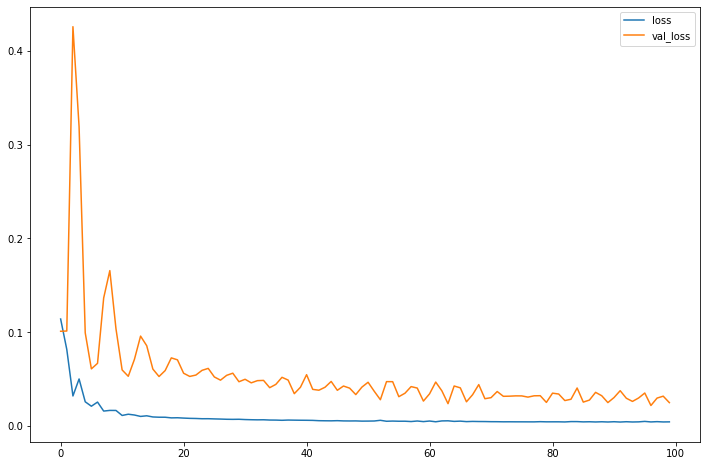

In [15]:
loss = pd.DataFrame(model1.history.history)
loss[['loss', 'val_loss']].plot(figsize = (12,8))

In [17]:
train_pred = model1.predict(trainX)
test_pred = model1.predict(testX)

In [18]:
# invert predictions
trainPredict = scaler.inverse_transform(train_pred)
trainActual = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(test_pred)
testActual = scaler.inverse_transform([testY])

In [19]:
metrics(trainPredict.reshape(-1), trainActual.reshape(-1))

MAE: 17.523355611165364
MSE: 424.2874286228325
RMSE: 20.598238483492526


In [20]:
metrics(testPredict.reshape(-1), testActual.reshape(-1))

MAE: 39.83156985328311
MSE: 2385.0239235381605
RMSE: 48.836706722896054


In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df, dtype='float')
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:trainPredict.shape[0]+look_back, :] = trainPredict

In [29]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(df, dtype='float')
testPredictPlot[:, :] = np.nan
testPredictPlot[trainPredict.shape[0]+(look_back*2)+1:df.shape[0]-1, :] = testPredict

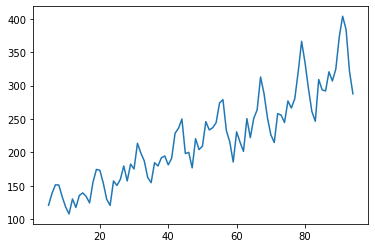

In [32]:
plt.plot(trainPredictPlot)

In [35]:
data = df['#Passengers'].values

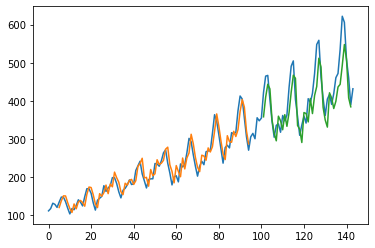

In [36]:
# plot baseline and predictions
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Time Series Generator

In [38]:
train_gen = TimeseriesGenerator(X_train_sc, X_train_sc, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(X_test_sc, X_test_sc, length=look_back, batch_size=1)

In [39]:
model2 = Simple_rnn_model()

In [40]:
model2.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 3s 11ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 3/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0679 - val_mse: 0.0679
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 8/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0074 - 

In [56]:
loss = pd.DataFrame(model2.history.history)

<AxesSubplot:>

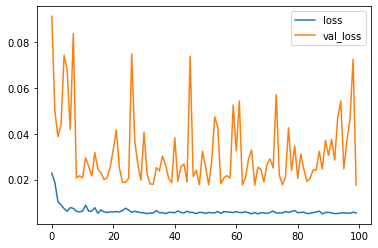

In [58]:
loss[['loss', 'val_loss']].plot()

In [116]:
def predictions_loop(model):
    train_predictions = []
    for i in train_gen:
        pred = model.predict(i[0])
        train_predictions.append(pred.reshape(-1))
    test_predictions = []
    for i in test_gen:
        pred = model.predict(i[0])
        test_predictions.append(pred.reshape(-1))
    train_predictions_inver = scaler.inverse_transform(np.array(train_predictions[:-1]))
    print('Train Metrics')
    metrics(trainActual.reshape(-1), train_predictions_inver)##Funtions
    test_predictions_inver = scaler.inverse_transform(np.array(test_predictions[:-1]))
    print('\nTest Metrics')
    metrics(testActual.reshape(-1), test_predictions_inver)##Funtions
    plot_figure(train_predictions_inver, test_predictions_inver)

In [117]:
def plot_figure(train_pred, test_pred):
    trainPredictPlot = np.empty_like(df, dtype='float')
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:trainPredict.shape[0]+look_back, :] = train_predictions_inver
    
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df, dtype='float')
    testPredictPlot[:, :] = np.nan
    testPredictPlot[trainPredict.shape[0]+(look_back*2)+1:df.shape[0]-1, :] = test_predictions_inver
    # plot baseline and predictions
    plt.figure(figsize=(12,8))
    plt.plot(data)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

Train Metrics
MAE: 21.386327192518447
MSE: 637.0394757096093
RMSE: 25.2396409584132

Test Metrics
MAE: 34.04947553362166
MSE: 1634.9956602366165
RMSE: 40.43507957500042


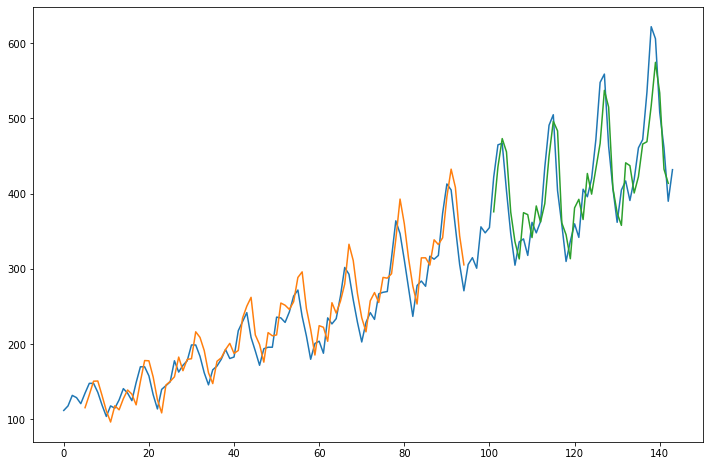

In [118]:
predictions_loop(model2)

#### Simple LSTM

In [119]:
def simple_lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape=(5,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [120]:
model3 = simple_lstm()

In [121]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [123]:
model3.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

Epoch 1/100
91/91 [==============================] - 3s 11ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.1016 - val_mse: 0.1016
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.1052 - val_mse: 0.1052
Epoch 3/100
91/91 [==============================] - 1s 7ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0675 - val_mse: 0.0675
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 7/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0134 - 

Train Metrics
MAE: 16.610589769151474
MSE: 413.73205372310866
RMSE: 20.340404463115

Test Metrics
MAE: 44.27144150506883
MSE: 2618.948413873558
RMSE: 51.17566231983283


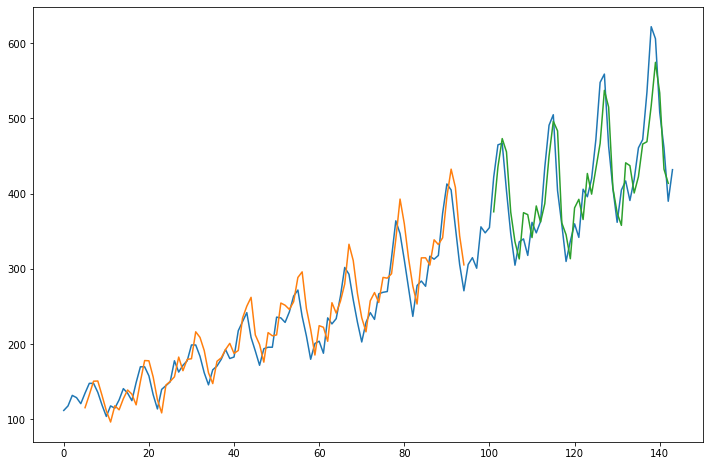

In [124]:
predictions_loop(model3)

#### Stacked LSTM

In [125]:
def stack_lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape=(5,1), return_sequences = True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [126]:
model3 = stack_lstm()

In [127]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [128]:
model3.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 5s 20ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.1188 - val_mse: 0.1188
Epoch 2/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.1388 - val_mse: 0.1388
Epoch 3/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 4/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0887 - val_mse: 0.0887
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 6/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 7/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0808 - val_mse: 0.0808
Epoch 8/100
91/91 [==============================] - 1s 8ms/step - loss: 0.015

Epoch 63/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 64/100
91/91 [==============================] - 7s 75ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 65/100
91/91 [==============================] - 2s 24ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 66/100
91/91 [==============================] - 2s 16ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 67/100
91/91 [==============================] - 1s 14ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 68/100
91/91 [==============================] - 2s 19ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 69/100
91/91 [==============================] - 2s 20ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 70/100
91/91 [==============================] - 2s 19ms/step - 

Train Metrics
MAE: 16.417323387993708
MSE: 393.5423124078629
RMSE: 19.83790090730022

Test Metrics
MAE: 41.5040508451916
MSE: 2324.148287060516
RMSE: 48.2094211442174


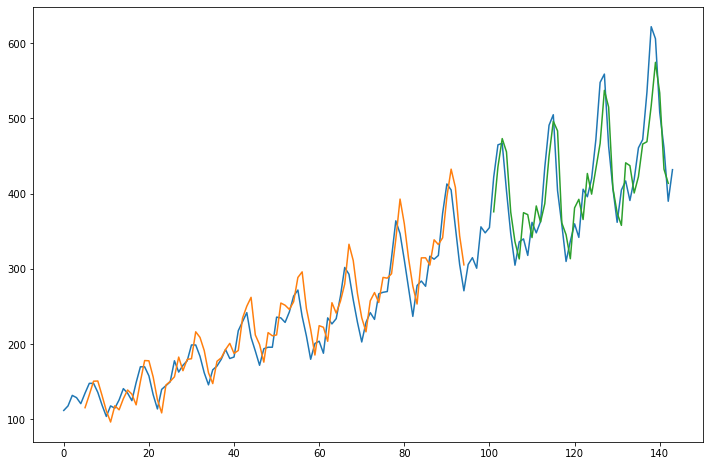

In [129]:
predictions_loop(model3)

#### Bidirectional LSTM

In [131]:
def bidirectional_lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape=(5,1), return_sequences = True))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [133]:
model4 = bidirectional_lstm()

In [134]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [135]:
model4.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 8s 26ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0843 - val_mse: 0.0843
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0878 - val_mse: 0.0878
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0953 - val_mse: 0.0953
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.1112 - val_mse: 0.1112
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 7/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 8/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0199 - 

Epoch 63/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 64/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 65/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 66/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 67/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 68/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 69/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 70/100
91/91 [==============================] - 1s 10ms/step - l

Train Metrics
MAE: 16.42267303466797
MSE: 378.6825888503265
RMSE: 19.459768468569365

Test Metrics
MAE: 39.756877354213174
MSE: 2283.937805136777
RMSE: 47.79056188345955


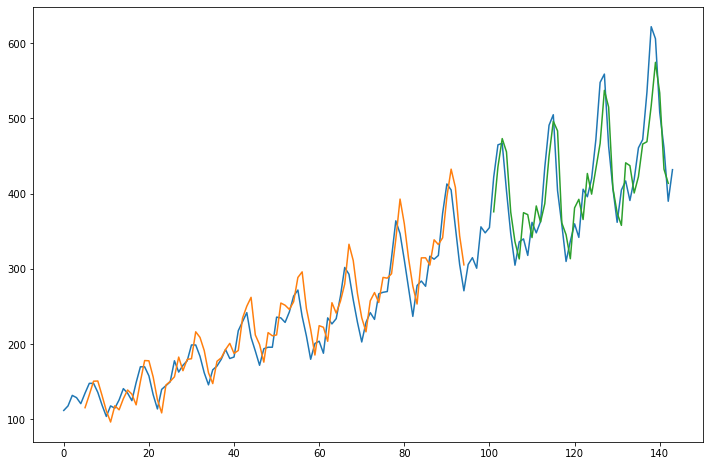

In [136]:
predictions_loop(model4)

###### Optimising  Learning Rate - ReduceLROnPlateau

In [138]:
callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5)]

In [139]:
model5 = bidirectional_lstm()

In [140]:
model5.fit_generator(train_gen, epochs = 100, validation_data=(test_gen), callbacks=callbacks)

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 8s 21ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.1337 - val_mse: 0.1337
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0844 - val_mse: 0.0844
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 7/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.1195 - val_mse: 0.1195
Epoch 8/100
91/91 [==============================] - 1s 12ms/step - loss: 0.0155 -

Epoch 63/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 64/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 65/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 66/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 67/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 68/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 69/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 70/100
91/91 [==============================] - 1s 9ms/step - loss: 0

Train Metrics
MAE: 16.433812204996745
MSE: 417.70956229754375
RMSE: 20.437944179822583

Test Metrics
MAE: 46.28746831984748
MSE: 2888.224722349928
RMSE: 53.742206154473486


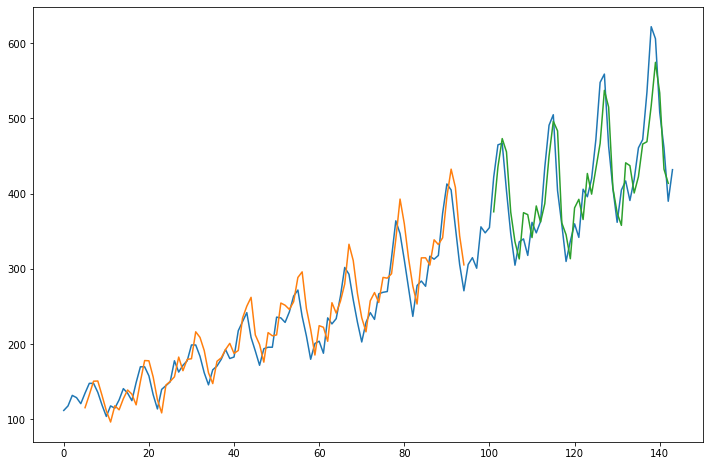

In [141]:
predictions_loop(model5)

#### GRU Model

In [142]:
def gru_model():
    model = Sequential()
    model.add(GRU(50, input_shape=(5,1), return_sequences = False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [143]:
model = gru_model()

In [144]:
###Reducing L.R
model.fit_generator(train_gen, epochs = 100, validation_data=(test_gen), callbacks=callbacks)

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 3s 11ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0966 - val_mse: 0.0966
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 5/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 7/100
91/91 [==============================] - 1s 7ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0095 -

Train Metrics
MAE: 17.068547905815972
MSE: 412.25208123409084
RMSE: 20.303991756156986

Test Metrics
MAE: 41.41857910156251
MSE: 2148.0289685099524
RMSE: 46.34683342484093


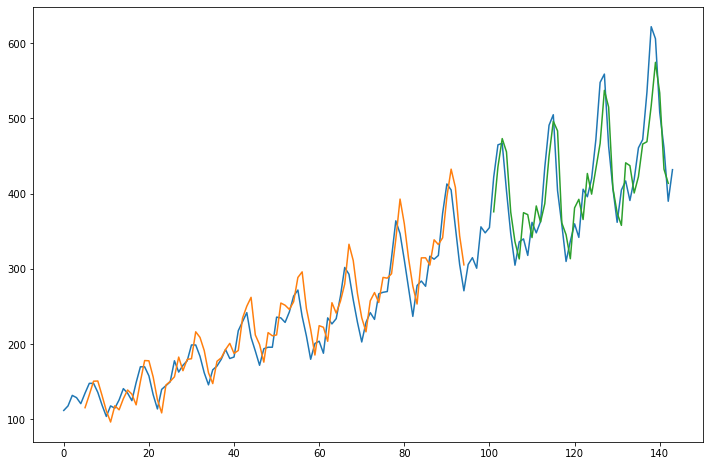

In [153]:
predictions_loop(model)

In [147]:
model_7 = gru_model()

In [148]:
###Without Reducing L.R
model_7.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 5s 14ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 2/100
91/91 [==============================] - 1s 7ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 3/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0698 - val_mse: 0.0698
Epoch 4/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 5/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 6/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 7/100
91/91 [==============================] - 1s 8ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0093 - 

91/91 [==============================] - 1s 6ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 64/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 65/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 66/100
91/91 [==============================] - 1s 7ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 67/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 68/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 69/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 70/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0045 - mse: 0

Train Metrics
MAE: 17.412666490342882
MSE: 431.5927104547064
RMSE: 20.77480951668887

Test Metrics
MAE: 37.38181195940291
MSE: 1977.7093077997151
RMSE: 44.47144373415052


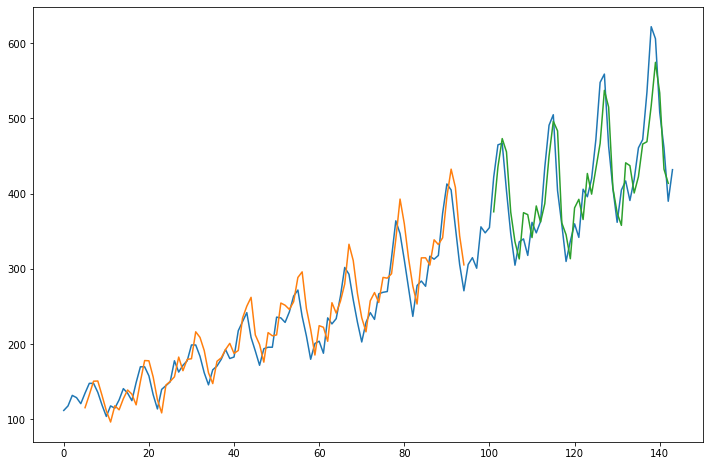

In [154]:
predictions_loop(model_7)

In [150]:
def gru_model_1():
    model = Sequential()
    model.add(GRU(50, input_shape=(5,1), return_sequences = False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
    return model

In [155]:
#SGD optimizer
model_8 = gru_model_1()

In [156]:
model_8.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 3s 10ms/step - loss: 0.0449 - mse: 0.0449 - val_loss: 0.2576 - val_mse: 0.2576
Epoch 2/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.1600 - val_mse: 0.1600
Epoch 3/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.1258 - val_mse: 0.1258
Epoch 4/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0746 - val_mse: 0.0746
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 6/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0102 - 

Train Metrics
MAE: 21.94509531656901
MSE: 764.1658616201577
RMSE: 27.643550090756392

Test Metrics
MAE: 53.817586263020836
MSE: 3894.2139581554984
RMSE: 62.4036373792065


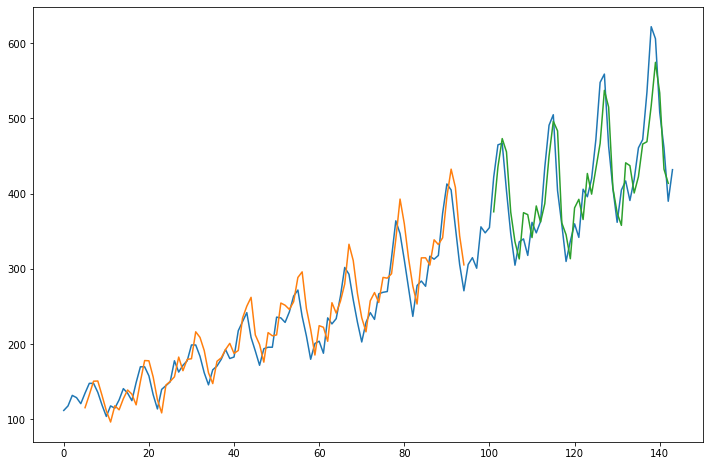

In [157]:
predictions_loop(model_8)

#### Stacked GRU

In [161]:
def stack_gru():
    model = Sequential()
    model.add(GRU(50, input_shape=(5,1), return_sequences = True))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [162]:
model_9 = stack_gru()

In [163]:
model_9.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 6s 17ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 2/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0680 - val_mse: 0.0680
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 7/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 8/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0090 -

Epoch 63/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 64/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 65/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 66/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 67/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 68/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 69/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 70/100
91/91 [==============================] - 1s 12ms/step - 

Train Metrics
MAE: 15.558224232991536
MSE: 352.64823748820214
RMSE: 18.778930680105354

Test Metrics
MAE: 48.01114472888766
MSE: 3520.6110889038323
RMSE: 59.33473762395712


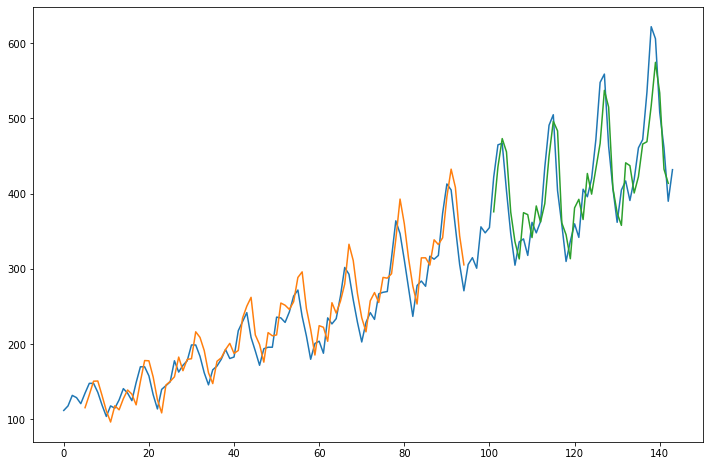

In [165]:
predictions_loop(model_9)

#### Bidirectional

In [164]:
def bidirec_gru():
    model = Sequential()
    model.add(GRU(50, input_shape=(5,1), return_sequences = True))
    model.add(Bidirectional(GRU(50)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [166]:
model_10 = bidirec_gru()

model_10.fit_generator(train_gen, epochs = 100, validation_data=(test_gen))

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 11s 39ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0960 - val_mse: 0.0960
Epoch 2/100
91/91 [==============================] - 2s 21ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0947 - val_mse: 0.0947
Epoch 3/100
91/91 [==============================] - 1s 14ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 4/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 5/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 6/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 7/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 8/100
91/91 [==============================] - 1s 12ms/step - loss: 0

Train Metrics
MAE: 16.33387891981337
MSE: 371.5683970185151
RMSE: 19.2761094886524

Test Metrics
MAE: 55.274491446358816
MSE: 4528.338543111221
RMSE: 67.29293085541171


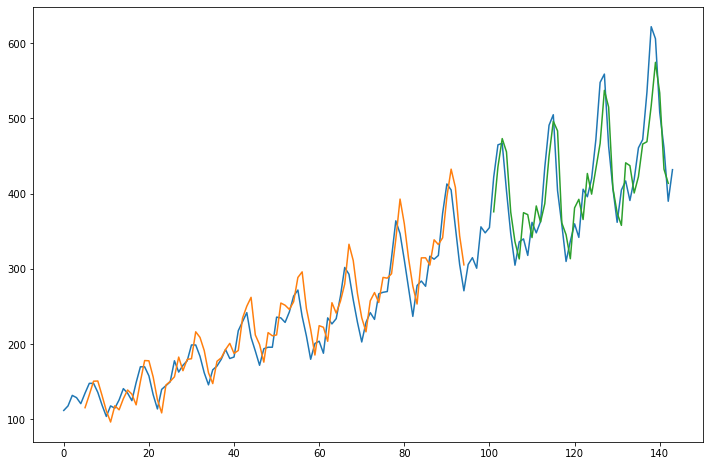

In [167]:
predictions_loop(model_10)

### Forecast

In [184]:
sc = MinMaxScaler()
df_scale = sc.fit_transform(df)

In [173]:
full_data = TimeseriesGenerator(df_scale, df_scale, length=5, batch_size=1)

In [175]:
forecast_model = Simple_rnn_model()

In [176]:
forecast_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 5, 50)             2600      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


In [178]:
forecast_model.fit_generator(full_data, epochs=100)

Epoch 1/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0125
Epoch 2/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0058 - mse: 0.0058
Epoch 3/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0064 - mse: 0.0064
Epoch 4/100
139/139 [==============================] - 1s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 5/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0050 - mse: 0.0050
Epoch 6/100
139/139 [==============================] - 1s 4ms/step - loss: 0.0063 - mse: 0.0063
Epoch 7/100
139/139 [==============================] - 1s 4ms/step - loss: 0.0043 - mse: 0.0043
Epoch 8/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048
Epoch 9/100
139/139 [==============================] - 1s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 10/100
139/139 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 11/100
139/139 [=================

###### Forecasting

In [180]:
look_back

5

In [181]:
full_data

In [182]:
n_features = 1

test_predictions = []

first_eval_batch = df_scale[-look_back:]

current_batch = first_eval_batch.reshape((1, look_back, n_features))

for i in range(0,12):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [185]:
test_pred = sc.inverse_transform(test_predictions)

In [199]:
df_forecast = np.empty_like(df, dtype='float')

In [200]:
df_forecast[:,:] = np.nan

In [201]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [208]:
index = pd.date_range(start='1949-01-01', periods=156, freq='MS')

In [206]:
np.append(df_forecast, test_pred).shape

(156,)

In [209]:
df_forecast_full=pd.DataFrame(data = np.append(df_forecast, test_pred), index = index)

In [211]:
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [210]:
df_forecast_full

,0
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1961-08-01,468.565571
1961-09-01,471.813211
1961-10-01,468.465690
1961-11-01,462.041980


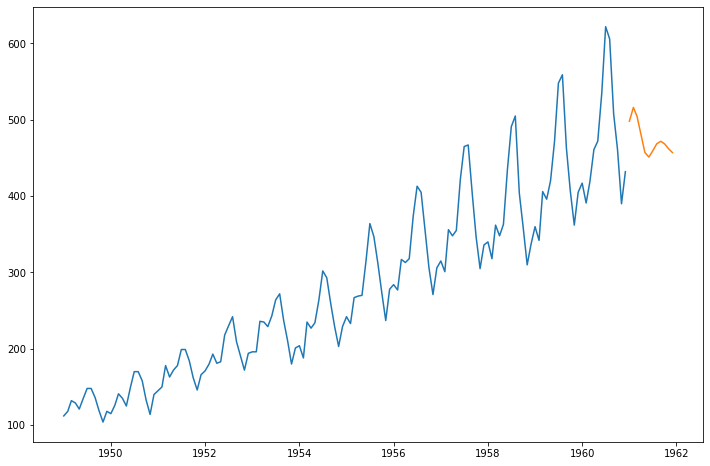

In [212]:
plt.figure(figsize=(12,8))
plt.plot(df['#Passengers'])
plt.plot(df_forecast_full)

#### SARIMA

In [9]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


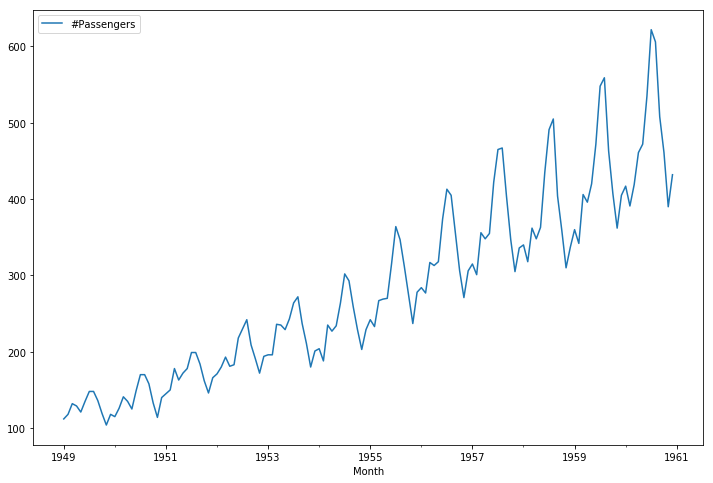

In [10]:
df.plot(figsize=(12,8))

In [13]:
auto_arima(df['#Passengers'], seasonal = True, m=12, suppress_warnings=True).summary()

/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/pmdarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 12)   Log Likelihood                -626.801
Date:                            Thu, 29 Jul 2021   AIC                           1267.601
Time:                                    09:26:20   BIC                           1288.341
Sample:                                         0   HQIC                          1276.029
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7024      0.168      4.169      0.000       0.372       1.033
ar.L1          1.4368      0.109     13.169      0.000       1.223       1.651
ar.L2         -0.7066      0.080     -8.815      0.000      -0.864      -0.549
ma.L1         -1.4832      0.174     -8.524      0.000      -1.824      -1.142
ma.L2          0.5033      0.175      2.877      0.004       0.160       0.846
ma.S.L12       0.7444      0.077      9.730      0.000       0.594       0.894
sigma2       345.6774     37.222      9.287      0.000     272.723     418.631
===================================================================================
Ljung-Box (Q):                      164.01   Jarque-Bera (JB):                10.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.46   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
###Split
train = df[:-12]
test = df[-12:]

In [18]:
train.shape

(132, 1)

In [19]:
test.shape

(12, 1)

In [20]:
model = SARIMAX(train['#Passengers'], order = (2,1,2), seasonal_order = (0,0,1,12))
results = model.fit()

/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 12)   Log Likelihood                -575.946
Date:                            Thu, 29 Jul 2021   AIC                           1163.892
Time:                                    09:30:35   BIC                           1181.143
Sample:                                01-01-1949   HQIC                          1170.902
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8059      0.043     41.773      0.000       1.721       1.891
ar.L2         -0.8783      0.043    -20.665      0.000      -0.962      -0.795
ma.L1         -1.9677      2.861     -0.688      0.492      -7.576       3.640
ma.L2          0.9997      2.908      0.344      0.731      -4.700       6.699
ma.S.L12       0.8097      0.102      7.923      0.000       0.609       1.010
sigma2       339.4059    993.023      0.342      0.733   -1606.884    2285.696
===================================================================================
Ljung-Box (Q):                      226.63   Jarque-Bera (JB):                 6.80
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               5.70   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start = len(train)
end = len(train)+len(test)-1

In [24]:
predictions = results.predict(start=start, end=end, typ='levels')

In [28]:
test.iloc[0,0]

417

In [31]:
for i in range(len(predictions)):
    print(f'Predictions:{int(predictions[i])}, Actual:{test.iloc[i,0]}')

Predictions:416, Actual:417
Predictions:403, Actual:391
Predictions:442, Actual:419
Predictions:443, Actual:461
Predictions:455, Actual:472
Predictions:471, Actual:535
Predictions:519, Actual:622
Predictions:527, Actual:606
Predictions:505, Actual:508
Predictions:480, Actual:461
Predictions:465, Actual:390
Predictions:498, Actual:432


In [33]:
predictions

1960-01-01    416.069209
1960-02-01    403.732928
1960-03-01    442.386911
1960-04-01    443.392537
1960-05-01    455.407526
1960-06-01    471.165109
1960-07-01    519.005847
1960-08-01    527.492270
1960-09-01    505.870668
1960-10-01    480.047499
1960-11-01    465.592905
1960-12-01    498.729987
Freq: MS, dtype: float64

In [37]:
test['Predictions'] = predictions.astype(int)

/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


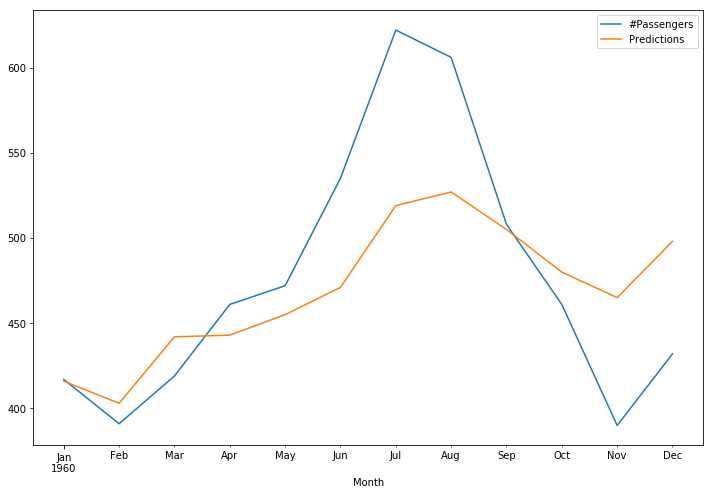

In [40]:
test.plot(figsize = (12,8))

In [44]:
metrics(test['#Passengers'], test['Predictions'])

MAE: 40.0
MSE: 2715.3333333333335
RMSE: 52.108860411002404


In [45]:
model = SARIMAX(train['#Passengers'], order = (2,1,2), seasonal_order = (0,0,1,12))
forecast = model.fit()

/Applications/anaconda3/envs/tsa_course/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [46]:
forecast.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 12)   Log Likelihood                -575.946
Date:                            Thu, 29 Jul 2021   AIC                           1163.892
Time:                                    09:39:12   BIC                           1181.143
Sample:                                01-01-1949   HQIC                          1170.902
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8059      0.043     41.773      0.000       1.721       1.891
ar.L2         -0.8783      0.043    -20.665      0.000      -0.962      -0.795
ma.L1         -1.9677      2.861     -0.688      0.492      -7.576       3.640
ma.L2          0.9997      2.908      0.344      0.731      -4.700       6.699
ma.S.L12       0.8097      0.102      7.923      0.000       0.609       1.010
sigma2       339.4059    993.023      0.342      0.733   -1606.884    2285.696
===================================================================================
Ljung-Box (Q):                      226.63   Jarque-Bera (JB):                 6.80
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               5.70   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
start = len(df)
end = start+23

In [57]:
predictions = forecast.predict(start=start, end=end, typ='levels').rename('SARIMA Forecast')

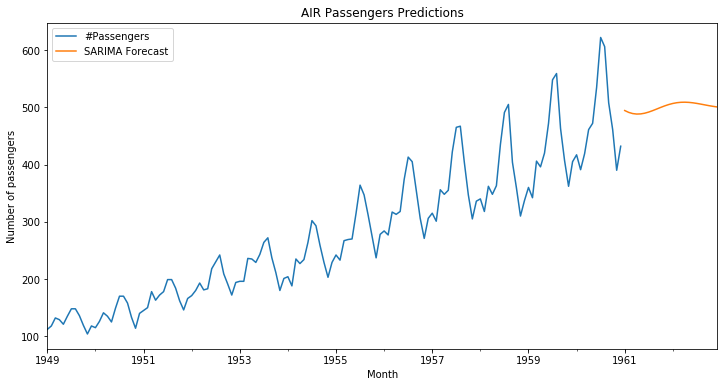

In [58]:
title = 'AIR Passengers Predictions'
ylabel='Number of passengers'
xlabel='Month'

ax = df['#Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);